In [1]:
#!/usr/bin/env python3

from math import sin, pi
from types import FunctionType

def rectangle(actual_minute, minute_start, minute_end):
    if minute_end < minute_start: 
        actual_minute += minute_end
        minute_end += 60 * 24

    if actual_minute < minute_start or actual_minute > minute_end: return 0
    else: return 1

def triangle(actual_minute, minute_start, minute_end, top = 0.5):
    if minute_end < minute_start: 
        actual_minute += minute_end
        minute_end += 60 * 24
    
    gap = (minute_end - minute_start)
    minute_top = minute_start + gap*top
    
    if(actual_minute < minute_start or actual_minute > minute_end): return 0
    elif(actual_minute >= minute_start and actual_minute <= minute_top):
        m = 1 / (minute_top - minute_start)
        b = -m*minute_start
    else:
        m = 1 / (minute_top - minute_end)
        b = -m*minute_end
    return m*actual_minute + b

def trapezoid(actual_minute, minute_start, minute_end, q1 = 0.25, q2 = 0.75):
    if minute_end < minute_start: 
        actual_minute += minute_end
        minute_end += 60 * 24
    
    gap = (minute_end - minute_start)
    minute_q1 = minute_start + gap*q1
    minute_q2 = minute_start + gap*q2

    if actual_minute < minute_start or actual_minute > minute_end: return 0
    elif actual_minute >= minute_start and actual_minute <= minute_q1: return triangle(actual_minute, minute_start, minute_q1, 1)
    elif actual_minute >= minute_q1 and actual_minute <= minute_q2: return rectangle(actual_minute, minute_q1, minute_q2)
    else: return triangle(actual_minute, minute_q2, minute_end, 0.001)


def sine(actual_minute, minute_start, minute_end):
    if minute_end < minute_start: 
        actual_minute += minute_end
        minute_end += 60 * 24
    
    if actual_minute < minute_start or actual_minute > minute_end:
        return 0
    else:
        f = pi/(minute_end - minute_start)
        return sin(f*(actual_minute - minute_start))

In [4]:
class Day:
    def __init__(self):
        self.fl = 0
        self.functions = []
        self.multiplier = []
        self.normalize = []
        self.intensity = []
        self.update = []
        
    def set_function(self, data):
        self.fl = data['floors']
        
        for i in range(self.fl):
            fn = data[i+1]
            # Linear Composition of multiple functions
            if(fn['type']=='multiple'):
                functionComposition = ''
                for j in range(fn['number_functions']):
                    func = fn[j+1]
                    start = func['start']['hour']*60 + func['start']['minute']
                    end = func['end']['hour']*60 + func['end']['minute']
                    if(func['type'] == 'rectangle'): singleFun = 'rectangle(a, {}, {}) '.format(start, end)
                    elif(func['type'] == 'triangle'): singleFun = 'triangle(a, {}, {}, {}) '.format(start, end, func['top'])
                    elif(func['type'] == 'trapezoid'): singleFun = 'trapezoid(a, {}, {}, {}, {}) '.format(start, end, func['q1'], func['q2'])
                    elif(func['type'] == 'sine'): singleFun = 'sine(a, {}, {}) '.format(start, end)
                    else: singleFun = '0'
                    functionComposition += '{}*{}'.format(func['multiplier'], singleFun)
                    if (j+1<fn['number_functions']): functionComposition += '+'
                myCode = 'def generic(a): return ({}) '.format(functionComposition)
            # Single function case
            else:
                start = fn['start']['hour']*60 + fn['start']['minute']
                end = fn['end']['hour']*60 + fn['end']['minute']
                if(fn['type'] == 'rectangle'): myCode = 'def generic(a): return rectangle(a, {}, {}) '.format(start, end)
                elif(fn['type'] == 'triangle'): myCode = 'def generic(a): return triangle(a, {}, {}, {}) '.format(start, end, fn['top'])
                elif(fn['type'] == 'trapezoid'): myCode = 'def generic(a): return trapezoid(a, {}, {}, {}, {}) '.format(start, end, fn['q1'], fn['q2'])
                elif(fn['type'] == 'sine'): myCode = 'def generic(a): return sine(a, {}, {}) '.format(start, end)
                else: myCode = 'def generic(actual_minute): return 0'
            
            print(myCode) # DEBUG
            code = (compile(myCode, "<int>", "exec"))
            self.functions.append(FunctionType(code.co_consts[0], globals(), "generic"))
            
            # Normalize the resulting function
            norm = 1
            if(fn['normalize']==True):
                self.normalize.append(True)
                for j in range(24*60):
                    aux = self.functions[i](j)
                    if(norm<aux): norm = aux
            else: self.normalize.append(False)
            
            # Fill the list
            self.multiplier.append(fn['multiplier']/norm)
            self.intensity.append(0) 
            self.update.append(False)
                
    def get_intensity(self, actual_minute):
        for i in range(self.fl): 
            aux = int(self.functions[i](actual_minute))
            if (aux>1 and not self.normalize[i]): aux = 1
            if(abs(aux-self.intensity[i])>1):
                self.intensity[i] = aux*self.multiplier[i]
                self.update[i] = True
    
    def reset_update(self):
        for i in range(self.fl): self.update[i] = False

In [13]:
#data = {'floors': 4, 
#        1: {'type':'rectangle', 'multiplier': 80, 'normalize': False, 'start': {'hour': 0, 'minute': 0}, 'end': {'hour': 10, 'minute': 0}}, 
#        2: {'type': 'triangle',  'multiplier': 80, 'normalize': False, 'start': {'hour': 0, 'minute': 0}, 'end': {'hour': 10, 'minute': 0}, 'top': 0.5}, 
#        3: {'type':'trapezoid',  'multiplier': 80, 'normalize': False, 'start': {'hour': 0, 'minute': 0}, 'end': {'hour': 10, 'minute': 0}, 'q1': 0.25, 'q2': 0.75}, 
#        4: {'type':'sine',  'multiplier': 80, 'normalize': False, 'start': {'hour': 0, 'minute': 0}, 'end': {'hour': 10, 'minute': 0}}}

data = {'floors': 1, 
        1:{'type': 'multiple', 'multiplier': 80, 'normalize': True, 'number_functions': 4, 
           1:{'type':'rectangle', 'multiplier': 2, 'start': {'hour': 0, 'minute': 1}, 'end': {'hour': 4, 'minute': 0}}, 
           2:{'type':'triangle', 'multiplier': 1, 'start': {'hour': 6, 'minute': 1}, 'end': {'hour': 10, 'minute': 0}, 'top': 0.5}, 
           3:{'type':'trapezoid', 'multiplier': 1, 'start': {'hour': 12, 'minute': 1}, 'end': {'hour': 16, 'minute': 0}, 'q1':0.25, 'q2':0.75}, 
           4:{'type':'sine', 'multiplier': 1, 'start': {'hour': 18, 'minute': 1}, 'end': {'hour': 22, 'minute': 0}} }}

day = Day()
day.set_function(data)

for i in range(24): 
    day.get_intensity(i*60)
    print(day.intensity)

def generic(a): return (2*rectangle(a, 1, 240) +1*triangle(a, 361, 600, 0.5) +1*trapezoid(a, 721, 960, 0.25, 0.75) +1*sine(a, 1081, 1320) ) 
[0.0]
[80.0]
[80.0]
[80.0]
[80.0]
[0.0]
[0.0]
[19.7489539748954]
[39.8326359832636]
[20.0836820083682]
[0.0]
[0.0]
[0.0]
[39.4979079497908]
[40.0]
[40.0]
[0.0]
[0.0]
[0.0]
[28.004059260360155]
[39.99913608227501]
[28.37706570104185]
[4.898587196589413e-15]
[0.0]


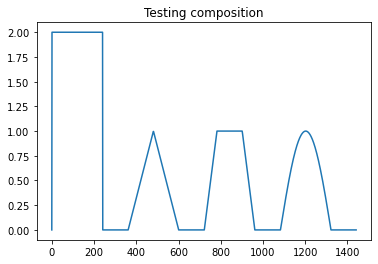

In [11]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

def generic(a): return (2*rectangle(a, 1, 240) +1*triangle(a, 361, 600, 0.5) +1*trapezoid(a, 721, 960, 0.25, 0.75) +1*sine(a, 1081, 1320) )

t = np.linspace(0, 24*60 + 1, 24*60)
y = []
for i in range(24*60): y.append(generic(i))
    
plt.plot(t, y)
plt.title('Testing composition')
plt.show()